# MES Experimental Analysis
This file contains all the experimental analysis required to prove the worth and place of the proposed cryptosystem, among the already existing pool

## Block Size vs Runtime

In [1]:
import numpy as np
from sympy import prime
from sympy.ntheory.modular import crt
import random
import time
from matplotlib import pyplot as plt
%matplotlib inline

## Cantor Pairing Function
This function takes in a point $(x,y)$ and converts to a single number $t$ and vice versa

In [2]:
def cantor_pair(k1, k2, safe=True):
    z = int(0.5 * (k1 + k2) * (k1 + k2 + 1) + k2)
    if safe and (k1, k2) != cantor_unpair(z):
        raise ValueError("{} and {} cannot be paired".format(k1, k2))
    return z

def cantor_unpair(z):
    w = np.floor((np.sqrt(8 * z + 1) - 1) / 2)
    t = (w**2 + w) / 2
    y = int(z - t)
    x = int(w - y)
    # assert z != pair(x, y, safe=False):
    return (x, y)

A padding function is required since we are applying a block cipher technique here

In [3]:
def padding(plain_text,block_size):
    plain_text += '0'*(block_size-len(plain_text))
    return plain_text

def chunkstring(string, length):
    return list(string[0+i:length+i] for i in range(0, len(string), length))

def reduced_ascii_chunks(ascii_chunks):
    cantor_reduced_list = []
    for i in range(0,len(ascii_chunks)-1,2):
        cantor_reduced_list.append(cantor_pair(ascii_chunks[i],ascii_chunks[i+1]))
    return cantor_reduced_list

In [4]:
def encrypt_decrypt(plain_text,block_size):
    t1 = time.time()
    n = len(plain_text)
    
    plain_text_chunks = []
    if n < block_size:
        plain_text_chunks.append(padding(plain_text,block_size))
    else:
        chunks = chunkstring(plain_text,block_size)
        for i in range(len(chunks)):
            plain_text_chunks.append(padding(chunks[i],block_size))

    ascii_chunks = []
    for chunk in plain_text_chunks:
        t = []
        for i in chunk:
            t.append(ord(i))
        ascii_chunks.append(t)

    cantor_reduced_list = []
    for chunk in ascii_chunks:
        cantor_reduced_list.append(reduced_ascii_chunks(chunk))
        
    temp = []
    for chunk in cantor_reduced_list:
        for i in chunk:
            temp.append(i)
    lower_index = max(temp)

    M = []
    for i in range(block_size//2):
        x = prime(random.randint(lower_index,lower_index+1000))
        if x not in M:
            M.append(x)

    # print('Private key generated : ',end='')
    # print(M)

    # Applying the Chinese Remainder Theorem to get X

    cipher_text = []
    for chunk in cantor_reduced_list:
        x = crt(M,chunk)
        cipher_text.append(round(x[0]))
    # print('Encrypted Cipher Text : ',cipher_text)


    # ---------------------------------DECRYPTION-----------------------------------
    # private_key - known
    # cipher_text - known
    # block_size  - known


    dec_M = M

    dec_cantor_reduced_list = []
    for x in cipher_text:
        t = []
        for mi in dec_M:
            t.append(x%mi)
        dec_cantor_reduced_list.append(t)
    # print(dec_cantor_reduced_list)

    decrypted_ascii_list = []
    for chunk in dec_cantor_reduced_list:
        t = []
        for i in range(len(chunk)):
            x,y = cantor_unpair(chunk[i])
            t.append(x)
            t.append(y)
        decrypted_ascii_list.append(t)
    
    decrypted_text_list = []
    for chunk in decrypted_ascii_list:
        for i in chunk:
            if chr(i)!='0':
                decrypted_text_list.append(chr(i))
    # print('Decrypted Text : ',end='')
    # print(''.join(map(lambda x:str(x),decrypted_text_list)))
    return time.time()-t1

We define a custom string for testing purposes

In [5]:
# plain_text = "Hello Fawlty Towers, how are you, its nice day"
plain_text = 'abcdefghijklmnopqrstuvwxyz'*1000

In [6]:
t_lst = []
for i in range(2, 257):
    block_size = i
    time_taken = encrypt_decrypt(plain_text, block_size)
    t_lst.append(time_taken)
    print('Block_size:'+str(i)+"  --------  Time:"+str(time_taken))


Block_size:2  --------  Time:0.3151109218597412
Block_size:3  --------  Time:0.16269254684448242
Block_size:4  --------  Time:0.301058292388916
Block_size:5  --------  Time:0.4296534061431885
Block_size:6  --------  Time:0.30712437629699707
Block_size:7  --------  Time:0.25951242446899414
Block_size:8  --------  Time:0.38043999671936035
Block_size:9  --------  Time:0.3296360969543457
Block_size:10  --------  Time:0.4409980773925781
Block_size:11  --------  Time:0.41253185272216797
Block_size:12  --------  Time:0.4725775718688965
Block_size:13  --------  Time:0.5027313232421875
Block_size:14  --------  Time:0.4830944538116455
Block_size:15  --------  Time:0.47850751876831055
Block_size:16  --------  Time:0.5471806526184082
Block_size:17  --------  Time:0.5586509704589844
Block_size:18  --------  Time:0.6840083599090576
Block_size:19  --------  Time:0.5301127433776855
Block_size:20  --------  Time:0.5292501449584961
Block_size:21  --------  Time:0.5130834579467773
Block_size:22  --------

Block_size:169  --------  Time:2.859368324279785
Block_size:170  --------  Time:2.9054291248321533
Block_size:171  --------  Time:2.901886224746704
Block_size:172  --------  Time:6.0920538902282715
Block_size:173  --------  Time:2.850105047225952
Block_size:174  --------  Time:2.9800212383270264
Block_size:175  --------  Time:69.17039918899536
Block_size:176  --------  Time:3.025533676147461
Block_size:177  --------  Time:3.3000640869140625
Block_size:178  --------  Time:3.0339951515197754
Block_size:179  --------  Time:3.0989017486572266
Block_size:180  --------  Time:3.0972001552581787
Block_size:181  --------  Time:3.0191237926483154
Block_size:182  --------  Time:3.12483286857605
Block_size:183  --------  Time:3.098531484603882
Block_size:184  --------  Time:3.153850555419922
Block_size:185  --------  Time:3.22874116897583
Block_size:186  --------  Time:3.3845608234405518
Block_size:187  --------  Time:3.1340529918670654
Block_size:188  --------  Time:3.2069268226623535
Block_size:

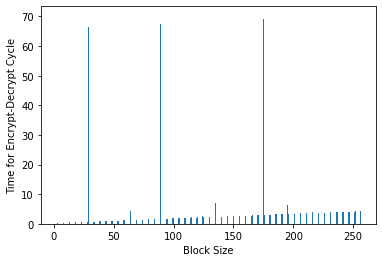

In [7]:
x = np.arange(2,257)  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
# Set position of bar on X axis
plt.bar(x, t_lst, width=width)
plt.xlabel('Block Size')
plt.ylabel('Time for Encrypt-Decrypt Cycle')
plt.show()

Curve Parameter (a,b) =  [0.02583131 1.20821134]


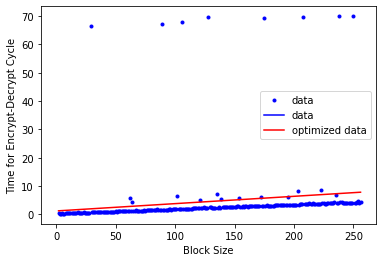

<Figure size 360x360 with 0 Axes>

In [10]:
from scipy import optimize

def test_func(x, a, b):
    return x*a+b 

param, param_cov = optimize.curve_fit(test_func, x, t_lst)
print('Curve Parameter (a,b) = ',param)
ans = (param[0]*x+param[1]) 
  
plt.plot(x, t_lst,'.',0.5, color ='blue', label ="data") 
plt.plot(x, ans,'-', color ='red', label ="optimized data") 
plt.xlabel('Block Size')
plt.ylabel('Time for Encrypt-Decrypt Cycle')
plt.legend()
plt.figure(figsize=(5,5))
plt.show() 

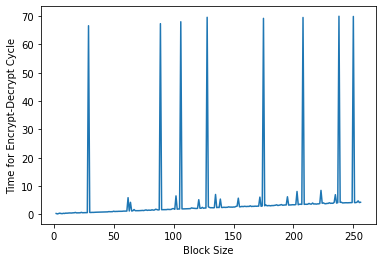

In [9]:
plt.plot(x, t_lst)
plt.xlabel('Block Size')
plt.ylabel('Time for Encrypt-Decrypt Cycle')
plt.show()